In [1]:
from prody import *
import numpy as np
import numba as nb
from sklearn.cluster import SpectralClustering, ward_tree
from sklearnex import patch_sklearn
from scipy.sparse.linalg import eigsh
import scipy
import os
import wget
import shutil
import gzip
import numba as nb
import matplotlib.pyplot as plt
import time
import psutil



Bad key "text.kerning_factor" on line 4 in
C:\Users\colin\Miniconda3\envs\idp\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [30]:
pdb = '1dwn'
n_modes = 90
filename = pdb + '.pdb'

if not os.path.exists(filename):
    vdb_url = 'https://files.rcsb.org/download/' + pdb + '.pdb.gz'
    print(vdb_url)
    vdb_filename = wget.download(vdb_url)
    with gzip.open(vdb_filename, 'rb') as f_in:
        with open(filename, 'wb') as f_out:
           shutil.copyfileobj(f_in, f_out)

In [31]:
capsid = parsePDB(filename, biomol=True)

calphas = capsid.select('ca').copy()
n = calphas.getCoords().shape[0]
print(n)
cutoff = 10

@> 2904 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Biomolecular transformations were applied to the coordinate data.


22860


In [32]:
type = 'anm'
if type == 'anm':
    anm = ANM(pdb + '_full')
    anm.buildHessian(calphas, cutoff=cutoff, kdtree=True, sparse=True)
    #print(calphas.shape[0])
    evals, evecs = eigsh(anm.getHessian(), k=n_modes, sigma=1E-5, which='LA')
    anm._eigvals = evals
    anm._n_modes = len(evals)
    anm._eigvecs = evecs
    anm._vars = 1/evals
    anm._array = evecs
    model = anm
elif type == 'gnm':
    gnm = GNM(pdb + '_full')
    gnm.buildKirchhoff(calphas, cutoff=cutoff, kdtree=True, sparse=True)
    print(calphas.getCoords().shape[0])
    evals, evecs = eigsh(gnm.getKirchhoff(), k=n_modes, sigma=1E-5, which='LA')
    gnm._eigvals = evals
    gnm._n_modes = len(evals)
    gnm._eigvecs = evecs
    gnm._vars = 1/evals
    gnm._array = evecs
    model = gnm

@> Using KDTree for building the Hessian.
@> Hessian was built in 53.13s.
C:\Users\colin\Miniconda3\envs\idp\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [33]:
@nb.njit(parallel=True)
def cov(evals, evecs, i, j):
    n_e = evals.shape[0]
    n_d = evecs.shape[1]
    tr1 = 0
    tr2 = 0
    tr3 = 0
    for n in nb.prange(n_e):
        l = evals[n]
        tr1 += 1 / l * (evecs[3 * i, n] * evecs[3 * j, n] + evecs[3 * i + 1, n] * evecs[3 * j + 1, n] + evecs[
            3 * i + 2, n] * evecs[3 * j + 2, n])
        # tr2 += 1 / l * (evecs[3 * i, n] * evecs[3 * i, n] + evecs[3 * i + 1, n] * evecs[3 * i + 1, n] + evecs[
        #     3 * i + 2, n] * evecs[3 * i + 2, n])
        # tr3 += 1 / l * (evecs[3 * j, n] * evecs[3 * j, n] + evecs[3 * j + 1, n] * evecs[3 * j + 1, n] + evecs[
        #     3 * j + 2, n] * evecs[3 * j + 2, n])
    cov = tr1 # / np.sqrt(tr2 * tr3)
    return cov

def con_c(evals, evecs, c, row, col):
    n_d = int(evecs.shape[0] / 3)
    n_e = evals.shape[0]

    for k in range(row.shape[0]):
        i, j = (row[k], col[k])
        c[i, j] = cov(evals, evecs, i, j)
    return c

def con_d(c, d, row, col):
    for k in range(row.shape[0]):
        i, j = (row[k], col[k])
        d[i, j] = 2 - 2 * c[i, j]
    return d

In [34]:
from scipy import sparse

evals = model.getEigvals()
evecs = model.getEigvecs()
n_d = int(evecs.shape[0] / 3)

kirch = model.getKirchhoff().tocoo()

covariance = sparse.lil_matrix((n_d, n_d))
df = sparse.lil_matrix((n_d, n_d))
covariance = con_c(evals, evecs, covariance, kirch.row, kirch.col)
covariance = covariance.tocsr()
d = con_d(covariance, df, kirch.row, kirch.col)
d = d.tocsr()

nnDistFlucts = np.mean(d.data)

sigma = 1 / (2 * nnDistFlucts ** 2)
sims = -sigma * d ** 2
data = sims.data
data = np.exp(data)
sims.data = data

In [37]:
def embedding(n_evecs, sims):
    print('Performing Spectral Embedding')
    from sklearnex import patch_sklearn
    patch_sklearn()
    from sklearn.manifold import spectral_embedding
    X_transformed = spectral_embedding(sims, n_components=n_evecs, drop_first=False, eigen_solver='amg')
    print('Memory Usage: ', psutil.virtual_memory().percent)
    return X_transformed

def embedding_manual(n_evecs, sims):
    from sklearn.preprocessing import normalize
    n = sims.shape[0]
    diags = scipy.sparse.csr_matrix.sum(sims, axis=1)
    diags = 1/(np.sqrt(diags))
    D = sparse.csr_matrix((n,n))
    D.setdiag(diags)
    I = scipy.sparse.identity(n)
    L = I - D @ sims @ D
    evals, evecs = eigsh(L, k=n_evecs, sigma=1E-5, which='LA')
    print(evecs.shape)
    embedding = normalize(evecs, axis=1)
    
    return embedding


In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from time import time
from kmeans_pytorch import kmeans, kmeans_predict

In [9]:
# dimensions, num clusters
dims, num_clusters = 2, 3

# data sizes
data_sizes = [100000, 1000000, 5000000, 10000000]

In [ ]:

gpu_times = []
cpu_times = []

for data_size in data_sizes:
    print(f'\ndata size: {data_size}')

    # data
    x = np.random.randn(data_size, dims) / 6
    x = torch.from_numpy(x)

    # gpu
    start_gpu = time()
    kmeans_gpu = kmeans(X=x, num_clusters=num_clusters, device=torch.device(0))
    gpu_time = time() - start_gpu
    gpu_times.append(gpu_time)
    print(f'gpu time: {gpu_time}')
    
    # cpu
    start_cpu = time()
    kmeans_cpu = kmeans(X=x, num_clusters=num_clusters, device=torch.device('cpu'))
    cpu_time = time() - start_cpu
    cpu_times.append(cpu_time)
    print(f'cpu time: {cpu_time}')


data size: 100000
running k-means on cuda:0..



[running kmeans]: 0it [00:00, ?it/s]
[running kmeans]: 0it [00:00, ?it/s, center_shift=0.081078, iteration=1, tol=0.000100]
[running kmeans]: 1it [00:00, 250.17it/s, center_shift=0.006660, iteration=2, tol=0.000100]
[running kmeans]: 2it [00:00, 333.37it/s, center_shift=0.002075, iteration=3, tol=0.000100]
[running kmeans]: 3it [00:00, 333.39it/s, center_shift=0.000707, iteration=4, tol=0.000100]
[running kmeans]: 4it [00:00, 363.58it/s, center_shift=0.000243, iteration=5, tol=0.000100]
[running kmeans]: 6it [00:00, 375.04it/s, center_shift=0.000075, iteration=6, tol=0.000100]


device is :cuda:0
device is :cuda:0
device is :cuda:0
device is :cuda:0
device is :cuda:0
device is :cuda:0
gpu time: 0.03999829292297363
running k-means on cpu..



[running kmeans]: 0it [00:00, ?it/s]
[running kmeans]: 0it [00:00, ?it/s, center_shift=0.144465, iteration=1, tol=0.000100]
[running kmeans]: 1it [00:00, 45.46it/s, center_shift=0.007156, iteration=2, tol=0.000100]
[running kmeans]: 2it [00:00, 60.60it/s, center_shift=0.001979, iteration=3, tol=0.000100]
[running kmeans]: 3it [00:00, 65.22it/s, center_shift=0.000616, iteration=4, tol=0.000100]
[running kmeans]: 4it [00:00, 65.57it/s, center_shift=0.000191, iteration=5, tol=0.000100]
[running kmeans]: 6it [00:00, 80.00it/s, center_shift=0.000069, iteration=6, tol=0.000100]


device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
cpu time: 0.08200240135192871

data size: 1000000
running k-means on cuda:0..



[running kmeans]: 0it [00:00, ?it/s]
[running kmeans]: 0it [00:00, ?it/s, center_shift=0.025511, iteration=1, tol=0.000100]
[running kmeans]: 1it [00:00, 166.66it/s, center_shift=0.016854, iteration=2, tol=0.000100]
[running kmeans]: 2it [00:00, 250.00it/s, center_shift=0.007211, iteration=3, tol=0.000100]


device is :cuda:0
device is :cuda:0
device is :cuda:0
device is :cuda:0


[running kmeans]: 3it [00:00, 272.70it/s, center_shift=0.001592, iteration=4, tol=0.000100]
[running kmeans]: 4it [00:00, 285.68it/s, center_shift=0.000504, iteration=5, tol=0.000100]
[running kmeans]: 5it [00:00, 312.49it/s, center_shift=0.000175, iteration=6, tol=0.000100]
[running kmeans]: 7it [00:00, 304.35it/s, center_shift=0.000058, iteration=7, tol=0.000100]


device is :cuda:0
device is :cuda:0
device is :cuda:0
gpu time: 0.05099940299987793
running k-means on cpu..



[running kmeans]: 0it [00:00, ?it/s]
[running kmeans]: 0it [00:00, ?it/s, center_shift=0.026171, iteration=1, tol=0.000100]
[running kmeans]: 1it [00:00,  9.22it/s, center_shift=0.026171, iteration=1, tol=0.000100]

device is :cpu
device is :cpu



[running kmeans]: 1it [00:00,  9.22it/s, center_shift=0.005824, iteration=2, tol=0.000100]
[running kmeans]: 2it [00:00,  9.39it/s, center_shift=0.005824, iteration=2, tol=0.000100]
[running kmeans]: 2it [00:00,  9.39it/s, center_shift=0.001413, iteration=3, tol=0.000100]
[running kmeans]: 3it [00:00,  9.45it/s, center_shift=0.001413, iteration=3, tol=0.000100]

device is :cpu
device is :cpu



[running kmeans]: 3it [00:00,  9.45it/s, center_shift=0.000407, iteration=4, tol=0.000100]
[running kmeans]: 4it [00:00,  9.45it/s, center_shift=0.000135, iteration=5, tol=0.000100]
[running kmeans]: 5it [00:00,  9.78it/s, center_shift=0.000135, iteration=5, tol=0.000100]


device is :cpu
device is :cpu


[running kmeans]: 6it [00:00,  9.73it/s, center_shift=0.000046, iteration=6, tol=0.000100]


cpu time: 0.6415085792541504

data size: 5000000
running k-means on cuda:0..



[running kmeans]: 0it [00:00, ?it/s]
[running kmeans]: 0it [00:00, ?it/s, center_shift=0.517971, iteration=1, tol=0.000100]
[running kmeans]: 1it [00:00, 100.00it/s, center_shift=0.027019, iteration=2, tol=0.000100]
[running kmeans]: 2it [00:00, 111.10it/s, center_shift=0.009437, iteration=3, tol=0.000100]
[running kmeans]: 3it [00:00, 130.44it/s, center_shift=0.003204, iteration=4, tol=0.000100]
[running kmeans]: 4it [00:00, 130.47it/s, center_shift=0.001079, iteration=5, tol=0.000100]
[running kmeans]: 5it [00:00, 140.09it/s, center_shift=0.000360, iteration=6, tol=0.000100]
[running kmeans]: 6it [00:00, 147.43it/s, center_shift=0.000122, iteration=7, tol=0.000100]
[running kmeans]: 8it [00:00, 134.09it/s, center_shift=0.000041, iteration=8, tol=0.000100]


device is :cuda:0
device is :cuda:0
device is :cuda:0
device is :cuda:0
device is :cuda:0
device is :cuda:0
device is :cuda:0
device is :cuda:0
gpu time: 0.2396697998046875
running k-means on cpu..



[running kmeans]: 0it [00:00, ?it/s]

device is :cpu



[running kmeans]: 0it [00:00, ?it/s, center_shift=0.108709, iteration=1, tol=0.000100]
[running kmeans]: 1it [00:00,  2.03it/s, center_shift=0.108709, iteration=1, tol=0.000100]

device is :cpu



[running kmeans]: 1it [00:00,  2.03it/s, center_shift=0.025875, iteration=2, tol=0.000100]
[running kmeans]: 2it [00:00,  2.06it/s, center_shift=0.025875, iteration=2, tol=0.000100]

device is :cpu



[running kmeans]: 2it [00:01,  2.06it/s, center_shift=0.008102, iteration=3, tol=0.000100]
[running kmeans]: 3it [00:01,  2.06it/s, center_shift=0.008102, iteration=3, tol=0.000100]

device is :cpu



[running kmeans]: 3it [00:01,  2.06it/s, center_shift=0.002483, iteration=4, tol=0.000100]
[running kmeans]: 4it [00:01,  2.02it/s, center_shift=0.002483, iteration=4, tol=0.000100]

device is :cpu



[running kmeans]: 4it [00:02,  2.02it/s, center_shift=0.000797, iteration=5, tol=0.000100]
[running kmeans]: 5it [00:02,  2.00it/s, center_shift=0.000797, iteration=5, tol=0.000100]

device is :cpu



[running kmeans]: 5it [00:02,  2.00it/s, center_shift=0.000265, iteration=6, tol=0.000100]
[running kmeans]: 6it [00:02,  2.00it/s, center_shift=0.000265, iteration=6, tol=0.000100]

device is :cpu



[running kmeans]: 6it [00:03,  2.00it/s, center_shift=0.000088, iteration=7, tol=0.000100]
[running kmeans]: 7it [00:03,  2.00it/s, center_shift=0.000088, iteration=7, tol=0.000100]


cpu time: 3.7115354537963867

data size: 10000000
running k-means on cuda:0..



[running kmeans]: 0it [00:00, ?it/s]
[running kmeans]: 0it [00:00, ?it/s, center_shift=0.042094, iteration=1, tol=0.000100]
[running kmeans]: 1it [00:00, 55.59it/s, center_shift=0.008635, iteration=2, tol=0.000100]
[running kmeans]: 2it [00:00, 57.15it/s, center_shift=0.002244, iteration=3, tol=0.000100]
[running kmeans]: 3it [00:00, 68.19it/s, center_shift=0.000691, iteration=4, tol=0.000100]
[running kmeans]: 4it [00:00, 74.09it/s, center_shift=0.000225, iteration=5, tol=0.000100]
[running kmeans]: 6it [00:00, 67.40it/s, center_shift=0.000074, iteration=6, tol=0.000100]


device is :cuda:0
device is :cuda:0
device is :cuda:0
device is :cuda:0
device is :cuda:0
device is :cuda:0
gpu time: 0.552739143371582
running k-means on cpu..



[running kmeans]: 0it [00:00, ?it/s]

device is :cpu



[running kmeans]: 0it [00:00, ?it/s, center_shift=0.043510, iteration=1, tol=0.000100]
[running kmeans]: 1it [00:00,  1.04it/s, center_shift=0.043510, iteration=1, tol=0.000100]

device is :cpu



[running kmeans]: 1it [00:01,  1.04it/s, center_shift=0.000512, iteration=2, tol=0.000100]
[running kmeans]: 2it [00:01,  1.06it/s, center_shift=0.000512, iteration=2, tol=0.000100]

device is :cpu



[running kmeans]: 2it [00:02,  1.06it/s, center_shift=0.000041, iteration=3, tol=0.000100]
[running kmeans]: 3it [00:02,  1.05it/s, center_shift=0.000041, iteration=3, tol=0.000100]

cpu time: 3.3101043701171875


In [78]:
torch.device(0)

device(type='cuda', index=0)

In [38]:
def kmed_cuda(n_range, maps):
    print('Clustering Embedded Points')

    import torch
    from kmeans_pytorch import kmeans

    from sklearn.metrics import silhouette_score
    from sklearn.metrics import davies_bouldin_score

    labels = []
    scores_km = []
    for n in range(len(n_range)):
        n_clusters = n_range[n]
        print('Clusters: ' + str(n_clusters))
        
        m = torch.from_numpy(maps[:, :n_clusters])

        label, cluster_centers = kmeans(
    X=m, num_clusters=n_clusters, distance='euclidean', device=torch.device(0), tol = 1e-10, tqdm_flag=False)
        
        label = label.numpy()
        labels.append(label)


        print('Scoring')
        testScore = davies_bouldin_score(maps[:, :n_clusters], label)
        scores_km.append(testScore)
        print('Memory Usage: ', psutil.virtual_memory().percent)

        print('Saving Results')
        domains = label
        nc = str(n_range[n])
        writePDB(pdb + '_' + nc + '_domains.pdb', calphas, beta=domains)

    return labels, scores_km

In [39]:
def kmed_embedding(n_range, maps):
    print('Clustering Embedded Points')


    from sklearn.cluster import KMeans
    from sklearn.cluster import k_means

    from sklearn.metrics import silhouette_score
    from sklearn.metrics import davies_bouldin_score

    labels = []
    scores_km = []
    for n in range(len(n_range)):
        n_clusters = n_range[n]
        print('Clusters: ' + str(n_clusters))

        # kmed = KMeans(n_clusters=n_clusters, n_init=200, tol=1e-8).fit(maps[:, :n_clusters])
        # labels.append(kmed.labels_)
        _, label, _ = k_means(maps[:, :n_clusters], n_clusters=n_clusters, n_init=10, tol=1e-8)
        labels.append(label)


        print('Scoring')
        testScore = davies_bouldin_score(maps[:, :n_clusters], label)
        scores_km.append(testScore)
        print('Memory Usage: ', psutil.virtual_memory().percent)

        print('Saving Results')
        domains = label
        nc = str(n_range[n])
        writePDB(pdb + '_' + nc + '_domains.pdb', calphas, beta=domains)

    return labels, scores_km

In [40]:
cluster_start, cluster_stop, cluster_step = 12, 60, 2

from sklearn.preprocessing import normalize
print(os.getcwd())
# os.chdir("../results/subdivisions/")
# if not os.path.exists(pdb):
#     os.mkdir(pdb)
# os.chdir(pdb)

print('Spectral Clustering')
n_range = np.arange(cluster_start, cluster_stop, cluster_step)
n_evecs = max(n_range)
start = time()
maps = embedding(n_evecs, sims)
end = time()
print(end - start, ' Seconds')
normalize(maps, copy=False)
start = time()
labels1, scores1 = kmed_cuda(n_range, maps)
end = time()
print(end - start, ' Seconds')

C:\Users\colin\OneDrive - San Diego State University (SDSU.EDU)\Research\Domain_Subdivision\mechanical_subdivision_ProDy\src
Spectral Clustering
Performing Spectral Embedding


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
C:\Users\colin\Miniconda3\envs\idp\lib\site-packages\pyamg\util\utils.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  1.0 / largest_row_entry[largest_row_entry != 0]
C:\Users\colin\Miniconda3\envs\idp\lib\site-packages\pyamg\util\utils.py:583: RuntimeWarning: divide by zero encountered in true_divide
  Dinv[mask] = 1.0 / D[mask]


Memory Usage:  34.9
6.012254238128662  Seconds
Clustering Embedded Points
Clusters: 12
Scoring
Memory Usage:  34.9
Saving Results
Clusters: 14
Scoring
Memory Usage:  34.9
Saving Results
Clusters: 16
Scoring
Memory Usage:  34.9
Saving Results
Clusters: 18
Scoring
Memory Usage:  34.9
Saving Results
Clusters: 20
Scoring
Memory Usage:  34.9
Saving Results
Clusters: 22
Scoring
Memory Usage:  34.9
Saving Results
Clusters: 24
Scoring
Memory Usage:  34.9
Saving Results
Clusters: 26
Scoring
Memory Usage:  35.0
Saving Results
Clusters: 28
Scoring
Memory Usage:  35.0
Saving Results
Clusters: 30
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 32
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 34
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 36
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 38
Scoring
Memory Usage:  35.0
Saving Results
Clusters: 40
Scoring
Memory Usage:  35.0
Saving Results
Clusters: 42
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 44
Scoring
Memory Us

In [41]:
cluster_start, cluster_stop, cluster_step = 12, 60, 2

from sklearn.preprocessing import normalize
print(os.getcwd())
# os.chdir("../results/subdivisions/")
# if not os.path.exists(pdb):
#     os.mkdir(pdb)
# os.chdir(pdb)

print('Spectral Clustering')
n_range = np.arange(cluster_start, cluster_stop, cluster_step)
n_evecs = max(n_range)
start = time()
maps = embedding(n_evecs, sims)
end = time()
print(end - start, ' Seconds')
normalize(maps, copy=False)
start = time()
labels2, scores2 = kmed_embedding(n_range, maps)
end = time()
print(end - start, ' Seconds')

C:\Users\colin\OneDrive - San Diego State University (SDSU.EDU)\Research\Domain_Subdivision\mechanical_subdivision_ProDy\src
Spectral Clustering
Performing Spectral Embedding


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
C:\Users\colin\Miniconda3\envs\idp\lib\site-packages\pyamg\util\utils.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  1.0 / largest_row_entry[largest_row_entry != 0]
C:\Users\colin\Miniconda3\envs\idp\lib\site-packages\pyamg\util\utils.py:583: RuntimeWarning: divide by zero encountered in true_divide
  Dinv[mask] = 1.0 / D[mask]


Memory Usage:  35.1
5.932612895965576  Seconds
Clustering Embedded Points
Clusters: 12
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 14
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 16
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 18
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 20
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 22
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 24
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 26
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 28
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 30
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 32
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 34
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 36
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 38
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 40
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 42
Scoring
Memory Usage:  35.1
Saving Results
Clusters: 44
Scoring
Memory Us

In [53]:
print(labels1)


[]


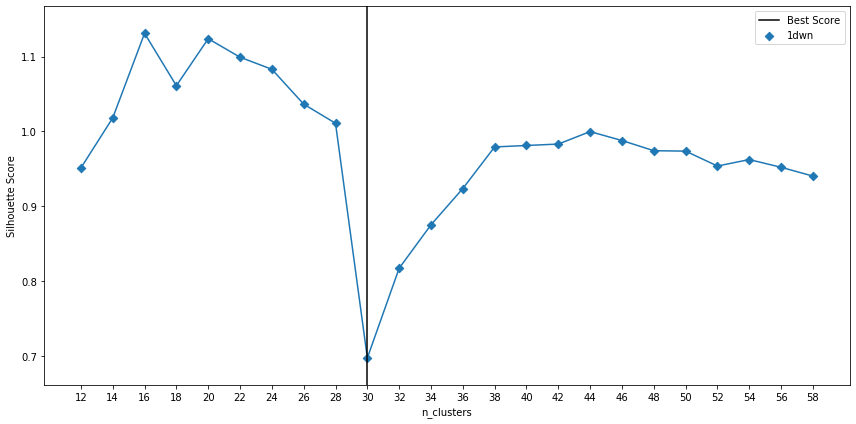

In [47]:
# cluster_similarity = [np.var(t)/(np.mean(t)) for t in cluster_types]
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.scatter(n_range, scores2, marker = 'D', label=pdb)
ax.plot(n_range, scores2)
ax.axvline(x = n_range[np.argmin(scores2)], label = 'Best Score', color = 'black')
ax.set_xticks(n_range)
ax.set_xlabel('n_clusters')
ax.set_ylabel('Silhouette Score')
ax.legend()
fig.tight_layout()
plt.show()

In [57]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
scores = []
devs = []
for n in range(len(n_range)):
    domains = labels[n]
    __, counts = np.unique(domains, return_counts = True)
    devs.append(np.std(counts))
    nc = str(n_range[n])
    writePDB(pdb + '_' + nc + '_domains.pdb',calphas,beta=domains)

In [58]:
n_range = [12, 20, 30] 

quality, labels1, cluster_types = spectral_raw(sims, calphas, n_range)

NameError: name 'spectral_raw' is not defined

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
scores = []
devs = []
for n in range(len(n_range)):
    domains = labels[n]
    __, counts = np.unique(domains, return_counts = True)
    devs.append(np.std(counts))
    testScore = silhouette_score(distFlucts, domains, metric='precomputed')
    scores.append(testScore)
    print(len(np.unique(domains)))
    nc = str(n_range[n])
    writePDB(pdb + '_' + nc + '_domains.pdb',calphas,beta=domains)



In [ ]:
# cluster_similarity = [np.var(t)/(np.mean(t)) for t in cluster_types]
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.scatter(n_range, scores, marker = 'D', label=pdb)
ax.plot(n_range, scores)
ax.axvline(x = n_range[np.argmax(scores)], label = 'Best Score', color = 'black')
ax.set_xticks(n_range)
ax.set_xlabel('n_clusters')
ax.set_ylabel('Silhouette Score')
ax.legend()
# ax[1].plot([32,60,90], cluster_types)
# ax[1].set_ylabel('Unique Clusters')
# fig.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
scores = []
devs = []
for n in range(len(n_range)):
    domains = labels1[n]
    __, counts = np.unique(domains, return_counts = True)
    devs.append(np.std(counts))
    testScore = silhouette_score(distFlucts, domains, metric='precomputed')
    scores.append(testScore)
    print(len(np.unique(domains)))
    nc = str(n_range[n])
    writePDB(pdb + '_' + nc + '_domains.pdb',calphas,beta=domains)



In [ ]:
# cluster_similarity = [np.var(t)/(np.mean(t)) for t in cluster_types]
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.scatter(n_range, scores, marker = 'D', label=pdb)
ax.plot(n_range, scores)
ax.axvline(x = n_range[np.argmax(scores)], label = 'Best Score', color = 'black')
ax.set_xticks(n_range)
ax.set_xlabel('n_clusters')
ax.set_ylabel('Silhouette Score')
ax.legend()
# ax[1].plot([32,60,90], cluster_types)
# ax[1].set_ylabel('Unique Clusters')
# fig.tight_layout()
plt.show()

In [ ]:
plt.plot(n_range, devs)

In [ ]:
import nglview
file = '1a34_20_domains.pdb'

view = nglview.show_file(file)  # load "3pqr" from RCSB PDB and display viewer widget
view.update_representation(color_scheme='bfactor')
view.background = 'black'
view